In [1]:
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from datetime import datetime
sns.set(style="whitegrid", font_scale=1.4)
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from numpy import argmax
from tqdm import trange

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
df = pd.read_csv('Data_set.csv')

In [3]:
df.head()

,Unnamed: 0,MONTH,DAY,M,BALL,SPEED_RES_PAS,SPEED_RES_FRE,SPEED_RES_EMPTY,SPEED_NORM_PAS,SPEED_NORM_FRE,...,O_4,O_T,delta_OTS_2,delta_OTS_3,delta_OTS_4,delta_O_1,delta_O_2,delta_O_3,delta_O_4,delta_O_T
0,5,1,19,1,10,1000,1000,1000,60,50,...,0,1,1,0,0,0,1,0,0,1
1,8,1,23,1,10,1000,1000,1000,140,90,...,0,1,-1,0,0,0,-1,0,0,-1
2,11,1,23,1,10,1000,1000,1000,160,90,...,0,0,-2,0,0,0,-2,0,0,-2
3,13,1,23,1,10,1000,1000,1000,160,90,...,0,0,0,0,0,0,0,0,0,0
4,15,1,23,1,10,1000,1000,1000,160,90,...,0,0,0,0,0,0,0,0,0,0


## Что-то из EDA

Введем еще один временнОй параметр в виде упорядоченных номеров месяцев. Т.е. у нас следующий год будет начинаться не с 1 месяца, а с 13 и заканчиваться 24 месяцем. Еще через год с 25. И т.д...

In [5]:
df['MONTH_ORDERED'] = df['MONTH']

In [6]:
df.loc[30438:, 'MONTH_ORDERED'] += 12
df.loc[59851:, 'MONTH_ORDERED'] += 12
df.loc[92347:, 'MONTH_ORDERED'] += 12

Закодируем признак MONTH в виде One-hot векторов, т.к. это дает прирост в ROC-AUC где-то на 0.01

In [7]:
df = pd.get_dummies(df, columns=["MONTH"])

Сгруппируем наши ТАРГЕТЫ по месяцам и по дням. Затем возьмем среднее и построим график.

In [8]:
graph_1 = df.groupby(["MONTH_ORDERED", "DAY"], as_index=False) \
    .aggregate({"TARGET": "mean"}) \
    .rename(columns = {"TARGET": "mean_target"})

In [9]:
# Функция, которая возвращает для сгруппированного датафрейма 
# столбец с типом datetime (чтобы было видно, что по оси ОХ)

def get_data(df, start_year=2015):
    df["date_time"] = 0
    for i in range(df.shape[0]):
        df["date_time"][i] = datetime(
            df['MONTH_ORDERED'][i] // 12 + start_year 
                if df['MONTH_ORDERED'][i] % 12 != 0 
                else df['MONTH_ORDERED'][i] // 12 + start_year - 1, 
            df['MONTH_ORDERED'][i] % 12 
                if df['MONTH_ORDERED'][i] % 12 != 0 
                else 12,
            df['DAY'][i]
        )

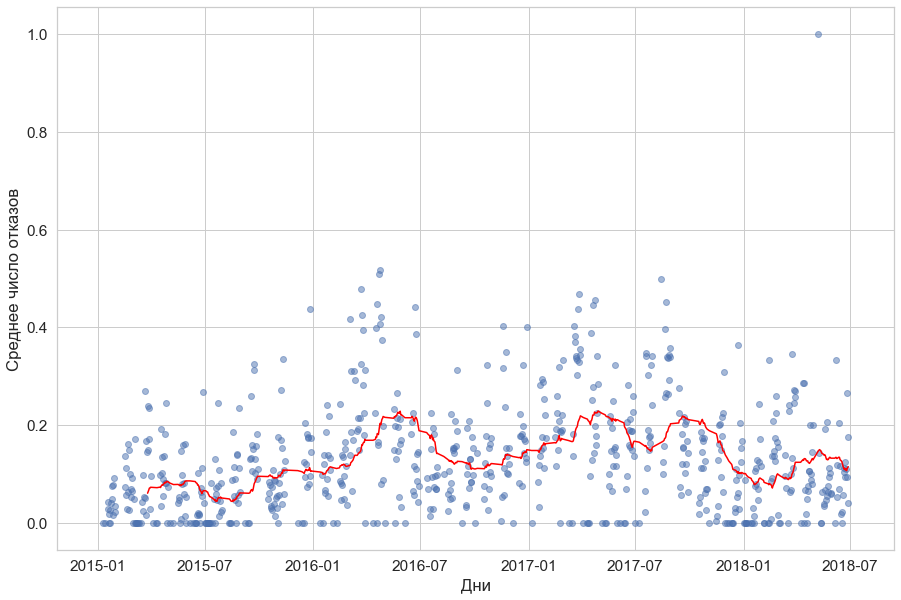

In [10]:
get_data(graph_1)

plt.figure(figsize=(15, 10))
plt.scatter(graph_1['date_time'], graph_1['mean_target'], alpha=0.5)
plt.plot(graph_1['date_time'], graph_1['mean_target'].rolling(50).mean(), color='red');
plt.xlabel('Дни')
plt.ylabel('Среднее число отказов')
plt.show()

Видно, что у нас есть один выброс в 2018 году. Вероятнее всего, в этот день померили одну сломанную дорогу и все. Поэтому для большей наглядности выкинем этот день.

In [11]:
graph_1 = graph_1.drop(graph_1[graph_1['mean_target'] == 1].index)

И снова построим графи + общее число проверок

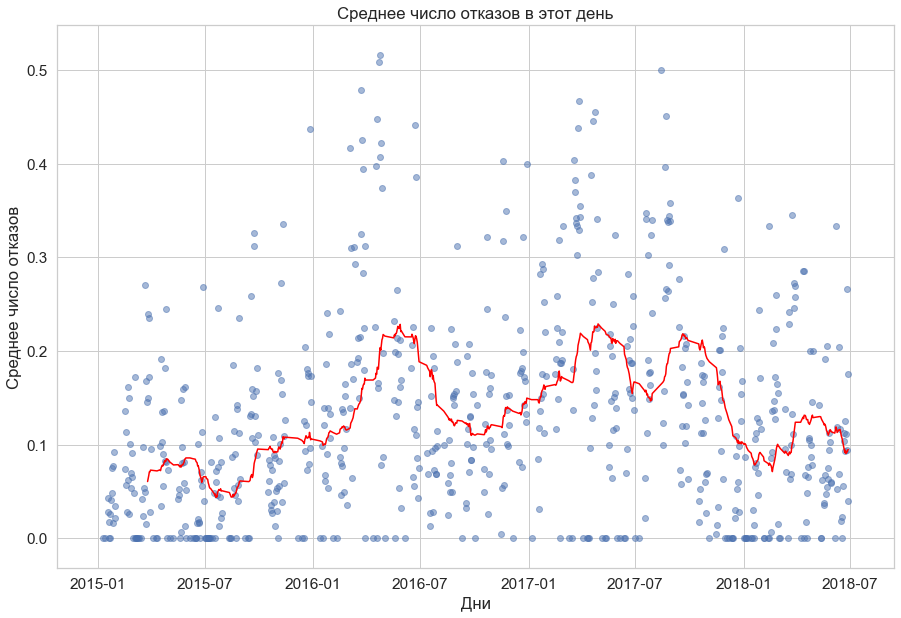

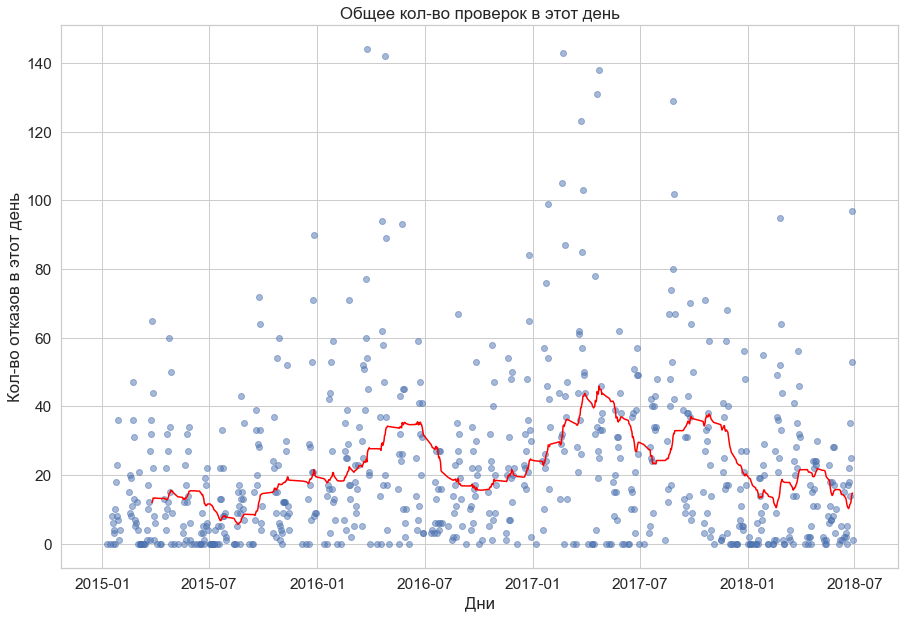

In [12]:
plt.figure(figsize=(15, 10))
plt.scatter(graph_1['date_time'], graph_1['mean_target'], alpha=0.5)
plt.plot(graph_1['date_time'], graph_1['mean_target'].rolling(50).mean(), color='red');
plt.xlabel('Дни')
plt.ylabel('Среднее число отказов')
plt.title('Среднее число отказов в этот день')
plt.show()

graph_3 = df.groupby(["MONTH_ORDERED", "DAY"], as_index=False) \
    .aggregate({"TARGET": "sum"}) \
    .rename(columns = {"TARGET": "sum"})
get_data(graph_3)

plt.figure(figsize=(15, 10))
plt.scatter(graph_3['date_time'], graph_3['sum'], alpha=0.5)
plt.plot(graph_3['date_time'], graph_3['sum'].rolling(50).mean(), color='red');
plt.xlabel('Дни')
plt.ylabel('Кол-во отказов в этот день')
plt.title('Общее кол-во проверок в этот день')
plt.show()

## Что я заметил
### Зимой кол-во отказов в летние месяцы в среднем меньше, чем в зимние месяцы за тот же год. 
Предположение 1. Летом рельсы под воздействием тепла больше склонны дифформироваться => выходить из строя

Предположение 2. Летом проводится больше измерений различных путей ЖД путей и мне кажется, что чем больше измерерний делается, тем больше отказов находят. 

### Хочу проверить предположение 2. 
Для этого строю график "Какое кол-во путей в день проверяется"

In [14]:
graph_2 = df.groupby(["MONTH_ORDERED", "DAY"], as_index=False) \
    .aggregate({"TARGET": "count"}) \
    .rename(columns = {"TARGET": "count"})

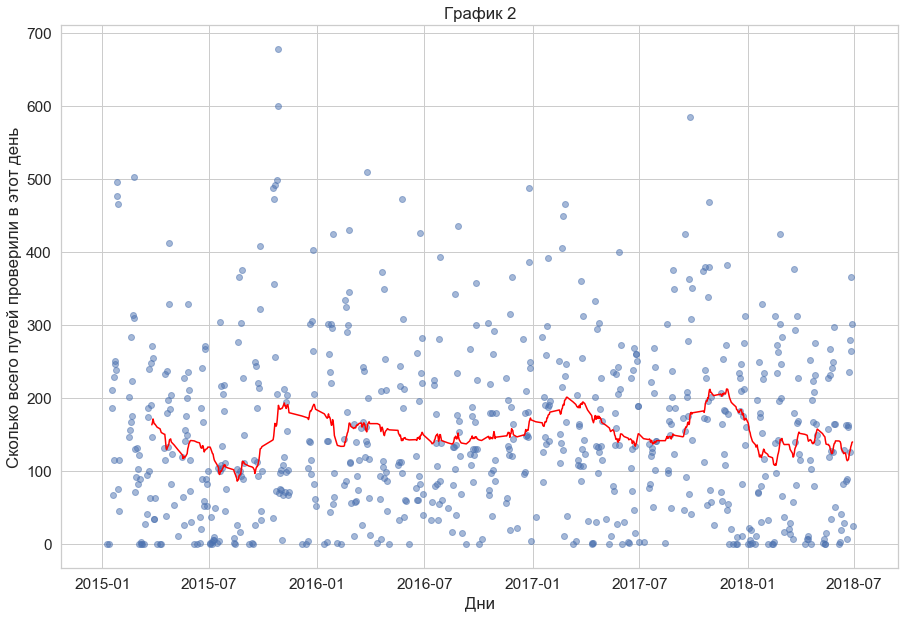

In [15]:
get_data(graph_2)

plt.figure(figsize=(15, 10))
plt.scatter(graph_2['date_time'], graph_2['count'], alpha=0.5)
plt.plot(graph_2['date_time'], graph_2['count'].rolling(50).mean(), color='red');
plt.xlabel('Дни')
plt.ylabel('Сколько всего путей проверили в этот день')
plt.title('График 2')
plt.show()

## Вывод из по этим трем графикам

### Видно, что в среднем  +- одинаковое кол-во проверок, НО 

Два горба в первой половине 2017 и конце 2017 года, совпадает с такими же горбами в 1-ом графике. Т.е. есть зависимость между ними все-таки. В принципе, можно сделать вывод, что кол-во отказов тем больше, чем больше в общей сложности было произведено проверок.

Но если посмотреть на лето 2016 года, то эта гипотеза не работает.